# Deep Q-Learning using Flappy Bird
1. **Question**: Since the game of Flappy bird can be frustrating and hard to complete, we want to know if it is possible to train an AI to complete the game using a machine learning techinques.

2. **Dataset**: With a pre-defined flappy bird game enviorment, we determine that our dataset will consist of every possbile game state combined with all possible actions and then train it to learn actions by using reward scores. We are hopeful that a combination of this data with a learning technique can effectively solve our problem.

3. **Method**: We decided that an effective techinque to solve our problem defined in (1) and using the dataset defined in (2), will be using reinforcement learning. At a high level, this method will train our agent when it takes an action in the flappy bird enviornment, and give it a score based on the outcome of the move. This way at each step we can learn from previous actions (rewards vs consequences) to determine the best overall score.

By -  
Shuai Yan (syan043)  
Bryce Hill (bhill007)  
Varun Sapre (vsapr002)  
  

# **Libraries Setup**


In [ ]:
!pip3 install torch==1.12.1 torchvision==0.13.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pygame
!pip install numpy
!pip install wget

In [ ]:
# PyGame related
from pygame import Rect, init, time, display
from pygame.event import pump
from pygame.image import load
from pygame.surfarray import array3d, pixels_alpha
from pygame.transform import rotate


# PyTorch related
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from itertools import cycle
from numpy.random import randint
from collections import deque
import random
import cv2
import pickle
import os
import numpy as np

pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


# **Environment**


The Environment is a pre-built flappy bird game which provides game data and images but DOES NOT provide any implementation of the agent that drives the game.

*NOTE:* Due to the way google-colab handles ".pth" files (it force converts to zip), they cannot be loaded in hosted runtimes. Please connect to a local runtime of jupyter-notebook for running it!

In [ ]:
# Un-comment these lines if trying to run on google-colab
# os.environ["SDL_VIDEODRIVER"] = "dummy"

# from google.colab import drive
# drive.mount('/content/drive')
# MAKE SURE TO UPLOAD ASSETS FOLDER TO YOUR GOOGLE DRIVE!

# asset_path_prefix='/content/drive/MyDrive/FlappyBirdAI/'

# import requests
# r = requests.get('https://github.com/Ryanshuai/flappy_bird_deep_q_learning/blob/main/pths/1_41.pth')
# with open("final.pth", 'wb') as f:
#     f.write(r.content)

In [ ]:
# Download the assets and pths folder from 'https://github.com/Ryanshuai/flappy_bird_deep_q_learning/' and insert the path to their parent folder below
asset_path_prefix='D:/github_project/flappy_bird_deep_q_learning/'

In [ ]:
class FlappyBird(object):
    init()
    fps_clock = time.Clock()
    screen_width = 288
    screen_height = 512
    screen = display.set_mode((screen_width, screen_height))
    display.set_caption('Deep Q-Network Flappy Bird')
    base_image = load(asset_path_prefix + 'assets/base.png').convert_alpha()
    background_image = load(asset_path_prefix + 'assets/background-black.png').convert()

    pipe_images = [rotate(load(asset_path_prefix + 'assets/pipe-green.png').convert_alpha(), 180),
                   load(asset_path_prefix + 'assets/pipe-green.png').convert_alpha()]
    bird_images = [load(asset_path_prefix + 'assets/redbird-upflap.png').convert_alpha(),
                   load(asset_path_prefix + 'assets/redbird-midflap.png').convert_alpha(),
                   load(asset_path_prefix + 'assets/redbird-downflap.png').convert_alpha()]
    # number_images = [load('assets/{}.png'.format(i)).convert_alpha() for i in range(10)]

    bird_hitmask = [pixels_alpha(image).astype(bool) for image in bird_images]
    pipe_hitmask = [pixels_alpha(image).astype(bool) for image in pipe_images]

    fps = 30
    pipe_gap_size = 100
    pipe_velocity_x = -4

    # parameters for bird
    min_velocity_y = -8
    max_velocity_y = 10
    downward_speed = 1
    upward_speed = -9

    bird_index_generator = cycle([0, 1, 2, 1])

    def __init__(self):

        self.iter = self.bird_index = self.score = 0

        self.bird_width = self.bird_images[0].get_width()
        self.bird_height = self.bird_images[0].get_height()
        self.pipe_width = self.pipe_images[0].get_width()
        self.pipe_height = self.pipe_images[0].get_height()

        self.bird_x = int(self.screen_width / 5)
        self.bird_y = int((self.screen_height - self.bird_height) / 2)

        self.base_x = 0
        self.base_y = self.screen_height * 0.79
        self.base_shift = self.base_image.get_width() - self.background_image.get_width()

        pipes = [self.generate_pipe(), self.generate_pipe()]
        pipes[0]["x_upper"] = pipes[0]["x_lower"] = self.screen_width
        pipes[1]["x_upper"] = pipes[1]["x_lower"] = self.screen_width * 1.5
        self.pipes = pipes

        self.current_velocity_y = 0
        self.is_flapped = False

    def generate_pipe(self):
        x = self.screen_width + 10
        gap_y = randint(2, 10) * 10 + int(self.base_y / 5)
        return {"x_upper": x, "y_upper": gap_y - self.pipe_height, "x_lower": x, "y_lower": gap_y + self.pipe_gap_size}

    def is_collided(self):
        # Check if the bird touch ground
        if self.bird_height + self.bird_y + 1 >= self.base_y:
            return True
        bird_bbox = Rect(self.bird_x, self.bird_y, self.bird_width, self.bird_height)
        pipe_boxes = []
        for pipe in self.pipes:
            pipe_boxes.append(Rect(pipe["x_upper"], pipe["y_upper"], self.pipe_width, self.pipe_height))
            pipe_boxes.append(Rect(pipe["x_lower"], pipe["y_lower"], self.pipe_width, self.pipe_height))
            # Check if the bird's bounding box overlaps to the bounding box of any pipe
            if bird_bbox.collidelist(pipe_boxes) == -1:
                return False
            for i in range(2):
                cropped_bbox = bird_bbox.clip(pipe_boxes[i])
                min_x1 = cropped_bbox.x - bird_bbox.x
                min_y1 = cropped_bbox.y - bird_bbox.y
                min_x2 = cropped_bbox.x - pipe_boxes[i].x
                min_y2 = cropped_bbox.y - pipe_boxes[i].y
                if np.any(self.bird_hitmask[self.bird_index][min_x1:min_x1 + cropped_bbox.width,
                       min_y1:min_y1 + cropped_bbox.height] * self.pipe_hitmask[i][min_x2:min_x2 + cropped_bbox.width,
                                                              min_y2:min_y2 + cropped_bbox.height]):
                    return True
        return False

    def next_frame(self, action):
        pump()
        reward = 0.1
        terminal = False
        # Check input action
        if action == 1:
            self.current_velocity_y = self.upward_speed
            self.is_flapped = True

        # Update score
        bird_center_x = self.bird_x + self.bird_width / 2
        for pipe in self.pipes:
            pipe_center_x = pipe["x_upper"] + self.pipe_width / 2
            if pipe_center_x < bird_center_x < pipe_center_x + 5:
                self.score += 5
                reward = 5
                break

        # Update index and iteration
        if (self.iter + 1) % 3 == 0:
            self.bird_index = next(self.bird_index_generator)
            self.iter = 0
        self.base_x = -((-self.base_x + 100) % self.base_shift)

        # Update bird's position
        if self.current_velocity_y < self.max_velocity_y and not self.is_flapped:
            self.current_velocity_y += self.downward_speed
        if self.is_flapped:
            self.is_flapped = False
        self.bird_y += min(self.current_velocity_y, self.bird_y - self.current_velocity_y - self.bird_height)
        if self.bird_y < 0:
            self.bird_y = 0

        # Update pipes' position
        for pipe in self.pipes:
            pipe["x_upper"] += self.pipe_velocity_x
            pipe["x_lower"] += self.pipe_velocity_x
        # Update pipes
        if 0 < self.pipes[0]["x_lower"] < 5:
            self.pipes.append(self.generate_pipe())
        if self.pipes[0]["x_lower"] < -self.pipe_width:
            del self.pipes[0]
        if self.is_collided():
            terminal = True
            reward = -1
            self.__init__()

        # Draw everything
        self.screen.blit(self.background_image, (0, 0))
        self.screen.blit(self.base_image, (self.base_x, self.base_y))
        self.screen.blit(self.bird_images[self.bird_index], (self.bird_x, self.bird_y))
        for pipe in self.pipes:
            self.screen.blit(self.pipe_images[0], (pipe["x_upper"], pipe["y_upper"]))
            self.screen.blit(self.pipe_images[1], (pipe["x_lower"], pipe["y_lower"]))
        image = array3d(display.get_surface())
        display.update()
        self.fps_clock.tick(self.fps)
        return image, reward, terminal

# **Neural Network**

The network involves 5 convolutional layers and 2 fully connected layers.

The convolutional layer can extract visual information from the environment, and the fully connected layer can integrate all information to obtain the Q-value corresponding to different action.

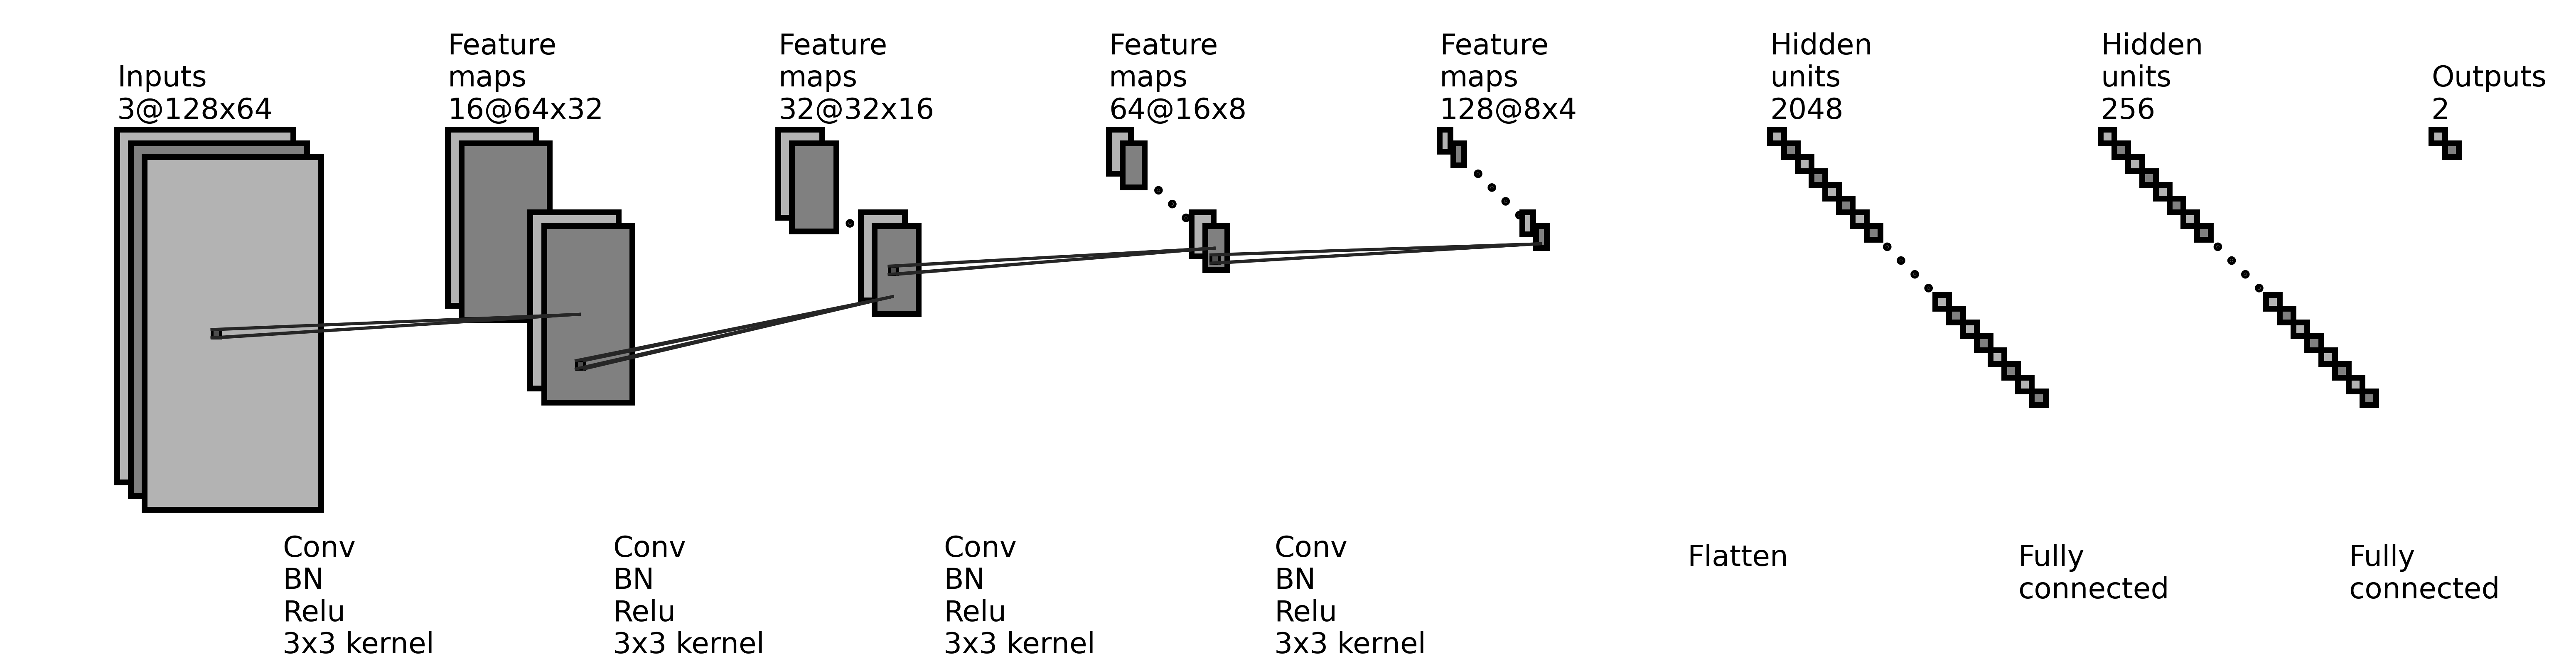

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NeuralNet(nn.Module):
    def __init__(self, load_path=None):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()

        self.fc1 = nn.Linear(2048, 256)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

        self.load(load_path)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))

        x = x.view(x.size(0), -1)
        x = self.relu6(self.fc1(x))
        x = self.fc2(x)

        return x

    def load(self, load_path=None):
        try:
            with open(load_path, "rb") as f:
                state_dict = torch.load(f, map_location=DEVICE)
            self.load_state_dict(state_dict)
            print("Model loaded from {}".format(load_path))
        except FileNotFoundError:
            print("No model parameter found. Starting from scratch.")

#**Memory**

The deep Q network use experience replay. The DQN create a replay "Buffer" that stores all the S.A.R.S. (State, Action, Reward, New State) experiences.

When training (learning), the Agent randomly chose the knowledge from the memory buffer.

In [ ]:
class Memory:
    def __init__(self, action_size, load_folder=None):
        self.action_size = action_size
        self.mem = deque(maxlen=10_000)
        if load_folder:
            self.from_disk(load_folder)

    def save(self, state, action, reward, next_state, done):
        state = state.transpose((2, 0, 1))
        next_state = next_state.transpose((2, 0, 1))
        action = np.eye(self.action_size)[action]
        self.mem.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        mem_sample = random.sample(self.mem, batch_size)
        state, action, reward, next_state, done = zip(*mem_sample)
        state = torch.from_numpy(np.array(state)).float().cuda()
        action = torch.from_numpy(np.array(action)).bool().cuda()
        reward = torch.from_numpy(np.array(reward)).float().cuda()
        next_state = torch.from_numpy(np.array(next_state)).float().cuda()
        done = torch.from_numpy(np.array(done)).int().cuda()
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.mem)

    def to_disk(self, save_name):
        with open(save_name, "wb") as f:
            pickle.dump(self.mem, f)

    def from_disk(self, load_name):
        try:
            with open(load_name, "rb") as f:
                self.mem = pickle.load(f)
        except FileNotFoundError:
            print("No memory found. Starting from scratch.")

#**Learning Agent**
For basic DQN, the neural network can estimate the Q value (accumulated reward) corresponding to different actions. The agent will choose the action with the larger Q value.

For actions, the agent will take random actions to explore and use max-Q actions to exploit previous experiences.

For learning, the agent will use Q(S,A) = A(S, A) + α(R+γQ(S', A') - Q(S, A)) to update the previous Q value. For the end state, the Q value is the immediate reward.

We used the DDQN algorithm, which involves 2 networks, and it uses a network with fixed parameters to estimate the Q value of the next state, which avoids overestimating the Q value and thus leads to faster convergence.

In [ ]:
class DQN_Agent:
    def __init__(self, action_size, train=True, pth=""):
        self.action_size = action_size
        self.memory = Memory(action_size, load_folder="memory")

        self.batch_size = 32
        self.gamma = 0.99

        self.model = NeuralNet(pth).to(DEVICE)
        self.model_fixed = NeuralNet(pth).to(DEVICE)
        self.writer = SummaryWriter("tensorboard/exp2")

        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-3)

        if train:
            self.random_action_probability = 0.01
            self.min_random_action_probability = 0.01
            self.random_action_probability_decay = 0.99_999
        else:
            self.random_action_probability = 0.0
            self.min_random_action_probability = 0.0
            self.random_action_probability_decay = 0.0

        self.observe_counter = 0
        self.learn_counter = 0

    def observe(self, state, action, reward, next_state, done):
        state = cv2.resize(state, (128, 64))
        next_state = cv2.resize(next_state, (128, 64))
        self.memory.save(state, action, reward, next_state, done)
        self.writer.add_scalar("Reward/reward", reward, self.learn_counter)

    def act(self, state):
        self.random_action_probability = max(self.random_action_probability * self.random_action_probability_decay,
                                             self.min_random_action_probability)

        if np.random.uniform(0, 1) < self.random_action_probability:
            p = np.array([0.9, 0.1])
            index = np.random.choice([0, 1], p=p.ravel())
            return index
        else:
            state = cv2.resize(state, (128, 64))
            state = state.transpose((2, 0, 1))
            state = torch.from_numpy(np.array(state)).float().cuda().unsqueeze(0)
            max_idx = torch.argmax(self.model_fixed(state)).item()
            return max_idx

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        state, action, reward, next_state, done = self.memory.sample(self.batch_size)

        q_fixed_next_state = self.model_fixed(next_state).detach()
        q_next_state = self.model(next_state).detach()
        next_q_value = q_fixed_next_state.gather(1, torch.max(q_next_state, 1)[1].unsqueeze(1)).squeeze(1)

        estimate_reward = reward + self.gamma * next_q_value * (1 - done)
        loss = self.loss_function(estimate_reward, self.model(state).masked_select(action))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_counter += 1

        if self.learn_counter % 10 == 0:
            self.model_fixed.load_state_dict(self.model.state_dict())

        if self.learn_counter % 10_000 == 0:
            self.memory.to_disk("memory")

        if self.learn_counter % 10_000 == 0:
            torch.save(self.model.state_dict(), asset_path_prefix+"pths" + os.sep + f"4_{self.learn_counter // 10_000}" + ".pth")

        self.writer.add_scalar('Loss', loss.item(), self.learn_counter)
        self.writer.add_scalar('Random Action Probability', self.random_action_probability, self.learn_counter)
        self.writer.add_scalar('Reward/q_value', torch.max(self.model(state)).item(), self.learn_counter)

The training process involves three steps.
1.    The agent observes the environment.
2.    The agent takes action based on the observation.
3.    Agent saves experience to memory and learns from memory.



In [ ]:
def train():
    agent = DQN_Agent(action_size=2, train=False, pth=asset_path_prefix + "pths/4_23.pth")

    env = FlappyBird()
    image, reward, terminal = env.next_frame(action=0)
    reward_sum = reward

    while True:
        action = agent.act(image)
        next_image, reward, terminal = env.next_frame(action)
        reward_sum += reward
        image = next_image

        if terminal:
            agent.writer.add_scalar("Reward/reward_sum", reward_sum, agent.learn_counter)
            print("reward_sum: ", reward_sum)
            env = FlappyBird()
            image, reward, terminal = env.next_frame(action=0)
            reward_sum = reward

In [ ]:
train()

Model loaded from D:/github_project/flappy_bird_deep_q_learning/pths/4_23.pth
Model loaded from D:/github_project/flappy_bird_deep_q_learning/pths/4_23.pth
reward_sum:  4.999999999999995
reward_sum:  4.999999999999995
reward_sum:  4.999999999999995
reward_sum:  27.20000000000003
reward_sum:  4.599999999999996
reward_sum:  44.400000000000134
reward_sum:  10.399999999999993
reward_sum:  10.399999999999993
reward_sum:  3.8999999999999986
reward_sum:  44.500000000000135
reward_sum:  10.799999999999992
reward_sum:  10.399999999999993
reward_sum:  3.8999999999999986
reward_sum:  13.299999999999983
reward_sum:  4.999999999999995
reward_sum:  18.69999999999998
reward_sum:  21.000000000000014
reward_sum:  44.600000000000136
reward_sum:  10.199999999999994
reward_sum:  46.80000000000017
reward_sum:  4.699999999999996
reward_sum:  10.099999999999994
reward_sum:  10.399999999999993
reward_sum:  10.199999999999994
reward_sum:  61.80000000000024
reward_sum:  3.8999999999999986
reward_sum:  4.9999999

KeyboardInterrupt: ignored

# **Sample Output of Agent Running**

In [ ]:
# loading screen recording of agent running on local system
from IPython.display import Image
Image(url='https://i.ibb.co/VNRQm9h/flappy-bird-2.gif')

#**Debug**

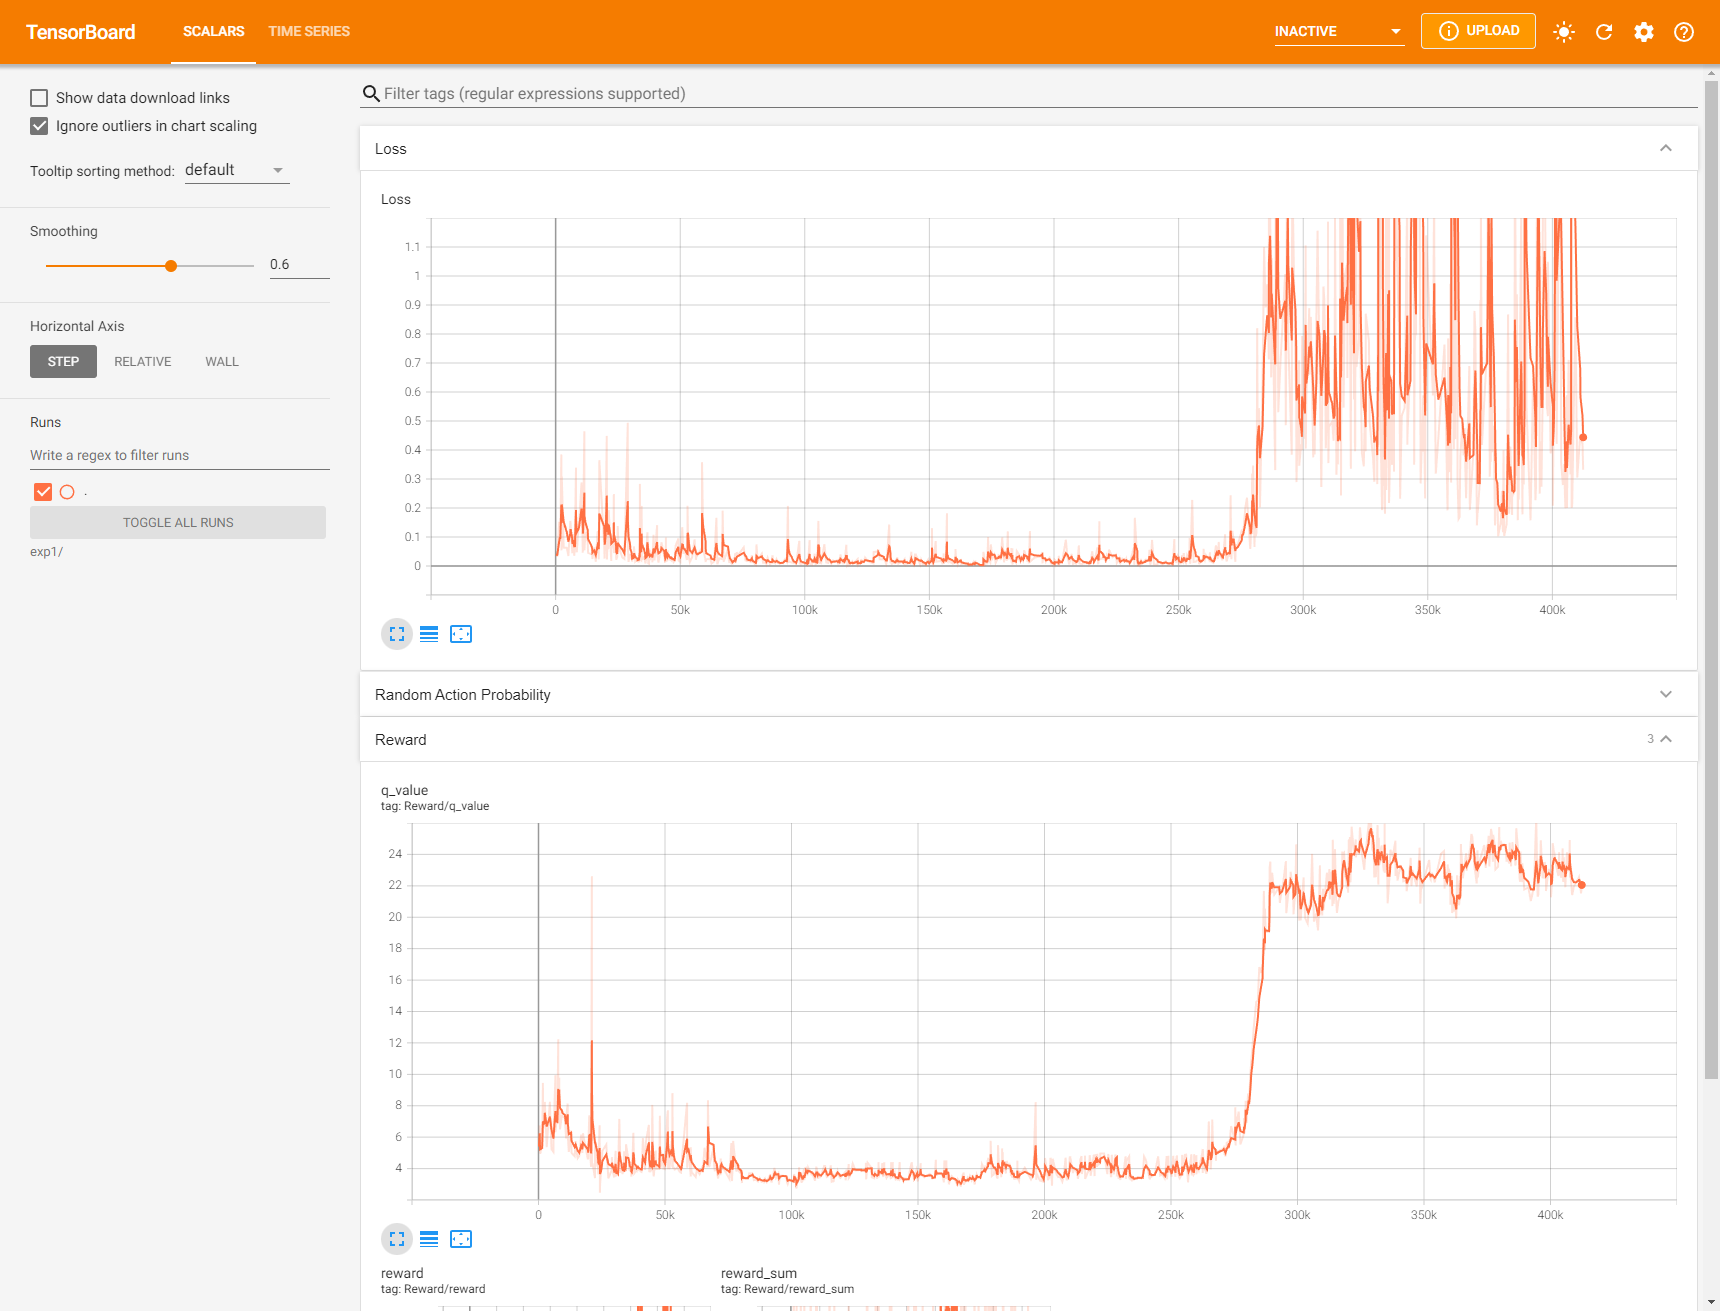